In [6]:
import os
import nibabel
import pydicom
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import h5py
import keras
import tensorflow as tf
from keras import backend as K
import h5py
from skimage import exposure

smoothDSC = np.finfo(float).eps

#cmap = colors.ListedColormap(['purple','red', 'green', 'blue', 'yellow', 'cyan', 'orange', "magenta"])
cmap = colors.ListedColormap(['purple','black','red', 'green', 'blue', 'yellow', 'cyan', 'orange', "magenta"])
                                      # Femur, femur_k, tibia, tibia_k, medial, lateral



# DICE Coeffizient für 3 Klassen Segmentierung
def dice_coef(y_true, y_pred, smooth=smoothDSC):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


# Inspiriert durch https://github.com/keras-team/keras/issues/9395

# DICE Coefficient für Mensiskus medialis
def dice_coef_medial(y_true, y_pred, epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:, :, :, 5])
    y_pred_f = K.flatten(y_pred[:, :, :, 5])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)


def dice_coef_lateral(y_true, y_pred, epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:, :, :, 6])
    y_pred_f = K.flatten(y_pred[:, :, :, 6])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)


def dice_coef_tibia(y_true, y_pred, epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:, :, :, 3])
    y_pred_f = K.flatten(y_pred[:, :, :, 3])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)


def dice_coef_femur(y_true, y_pred, epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:, :, :, 1])
    y_pred_f = K.flatten(y_pred[:, :, :, 1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)


def dice_coef_C_tibia(y_true, y_pred, epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:, :, :, 4])
    y_pred_f = K.flatten(y_pred[:, :, :, 4])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)


def dice_coef_C_femur(y_true, y_pred, epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:, :, :, 2])
    y_pred_f = K.flatten(y_pred[:, :, :, 2])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)


# Präzsion
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


# Sensitivität
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Spezifität
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


DATA_PATH = "../../data/"
TRAIN_DATASET_PATH = DATA_PATH + "training_data/InVivo/"
MODEL_PATH = DATA_PATH + "training_data/OAI_6/"

In [3]:

predictions = []
predictions.append(np.zeros((160, 384, 384)))
with h5py.File(TRAIN_DATASET_PATH + "MenisKI21_Prediction_10_InVivo_resized.h5", 'r') as hf:

    prediction_ids = [s[:-4] for s in list(hf.keys()) if "Test" in s.split("_") and "dcm" in s.split("_")]
    print(prediction_ids[0])
    model = keras.models.load_model(TRAIN_DATASET_PATH + "model_singles_InVivo_resized.h5",
                                         custom_objects={'accuracy': tf.keras.metrics.MeanIoU(num_classes=2),
                                                         "dice_coef": dice_coef,
                                                         "dice_coef_medial": dice_coef_medial,
                                                         "dice_coef_lateral": dice_coef_lateral,
                                                         "precision": precision,
                                                         "sensitivity": sensitivity,
                                                         "specificity": specificity,
                                                         },
                                         compile=False)
    model.compile()


    pred = model.predict(hf[prediction_ids[1] + "_dcm"][:], batch_size=15, verbose=1)


    # sample_stack(hf[prediction_ids[1] + '_dcm'][:], predictions[1], rows=2, cols=2, start_with=40, show_every=2)
    # sample_stack(hf[prediction_ids[1] + '_dcm'][:], predictions[2], rows=2, cols=2, start_with=40, show_every=2)
    # sample_stack(hf[prediction_ids[1] + '_dcm'][:], predictions[3], rows=2, cols=2, start_with=40, show_every=2)
    # sample_stack(hf[prediction_ids[1] + '_dcm'][:], predictions[4], rows=2, cols=2, start_with=40, show_every=2)
    # sample_stack(hf[prediction_ids[1] + '_dcm'][:], predictions[5], rows=2, cols=2, start_with=40, show_every=2)
    # sample_stack(hf[prediction_ids[1] + '_dcm'][:], predictions[6], rows=2, cols=2, start_with=40, show_every=2)


MenisKI21_Test_0001
5/5 [==============================] - 21s 4s/step


In [11]:

def sample_stack(stack, segmenation, rows=8, cols=8, start_with=20, show_every=2, fig_size = [30,30]):
    cmap = colors.ListedColormap(['purple','red', 'green', 'blue', 'yellow', 'cyan', 'orange', "magenta"])
                                        # Femur, femur_k, tibia, tibia_k, medial, lateral
    # Funktion, um MRT-Aufnahme (stack) und dazugehörige Segmentierung als Sammlung zu plotten
    bounds = [0, 1, 2, 3, 4, 5, 6, 7]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots(rows, cols, figsize=fig_size)
    for i in range(rows * cols):
        ind = start_with + i * show_every
        ax[int(i / rows), int(i % rows)].set_title('slice %d' % ind)
        ax[int(i / rows), int(i % rows)].imshow(stack[ind], cmap='gray', interpolation='none')
        ax[int(i / rows), int(i % rows)].imshow(np.ma.masked_where(segmenation[ind] == 0, segmenation[ind]),interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
        ax[int(i / rows), int(i % rows)].axis('off')
    plt.show()

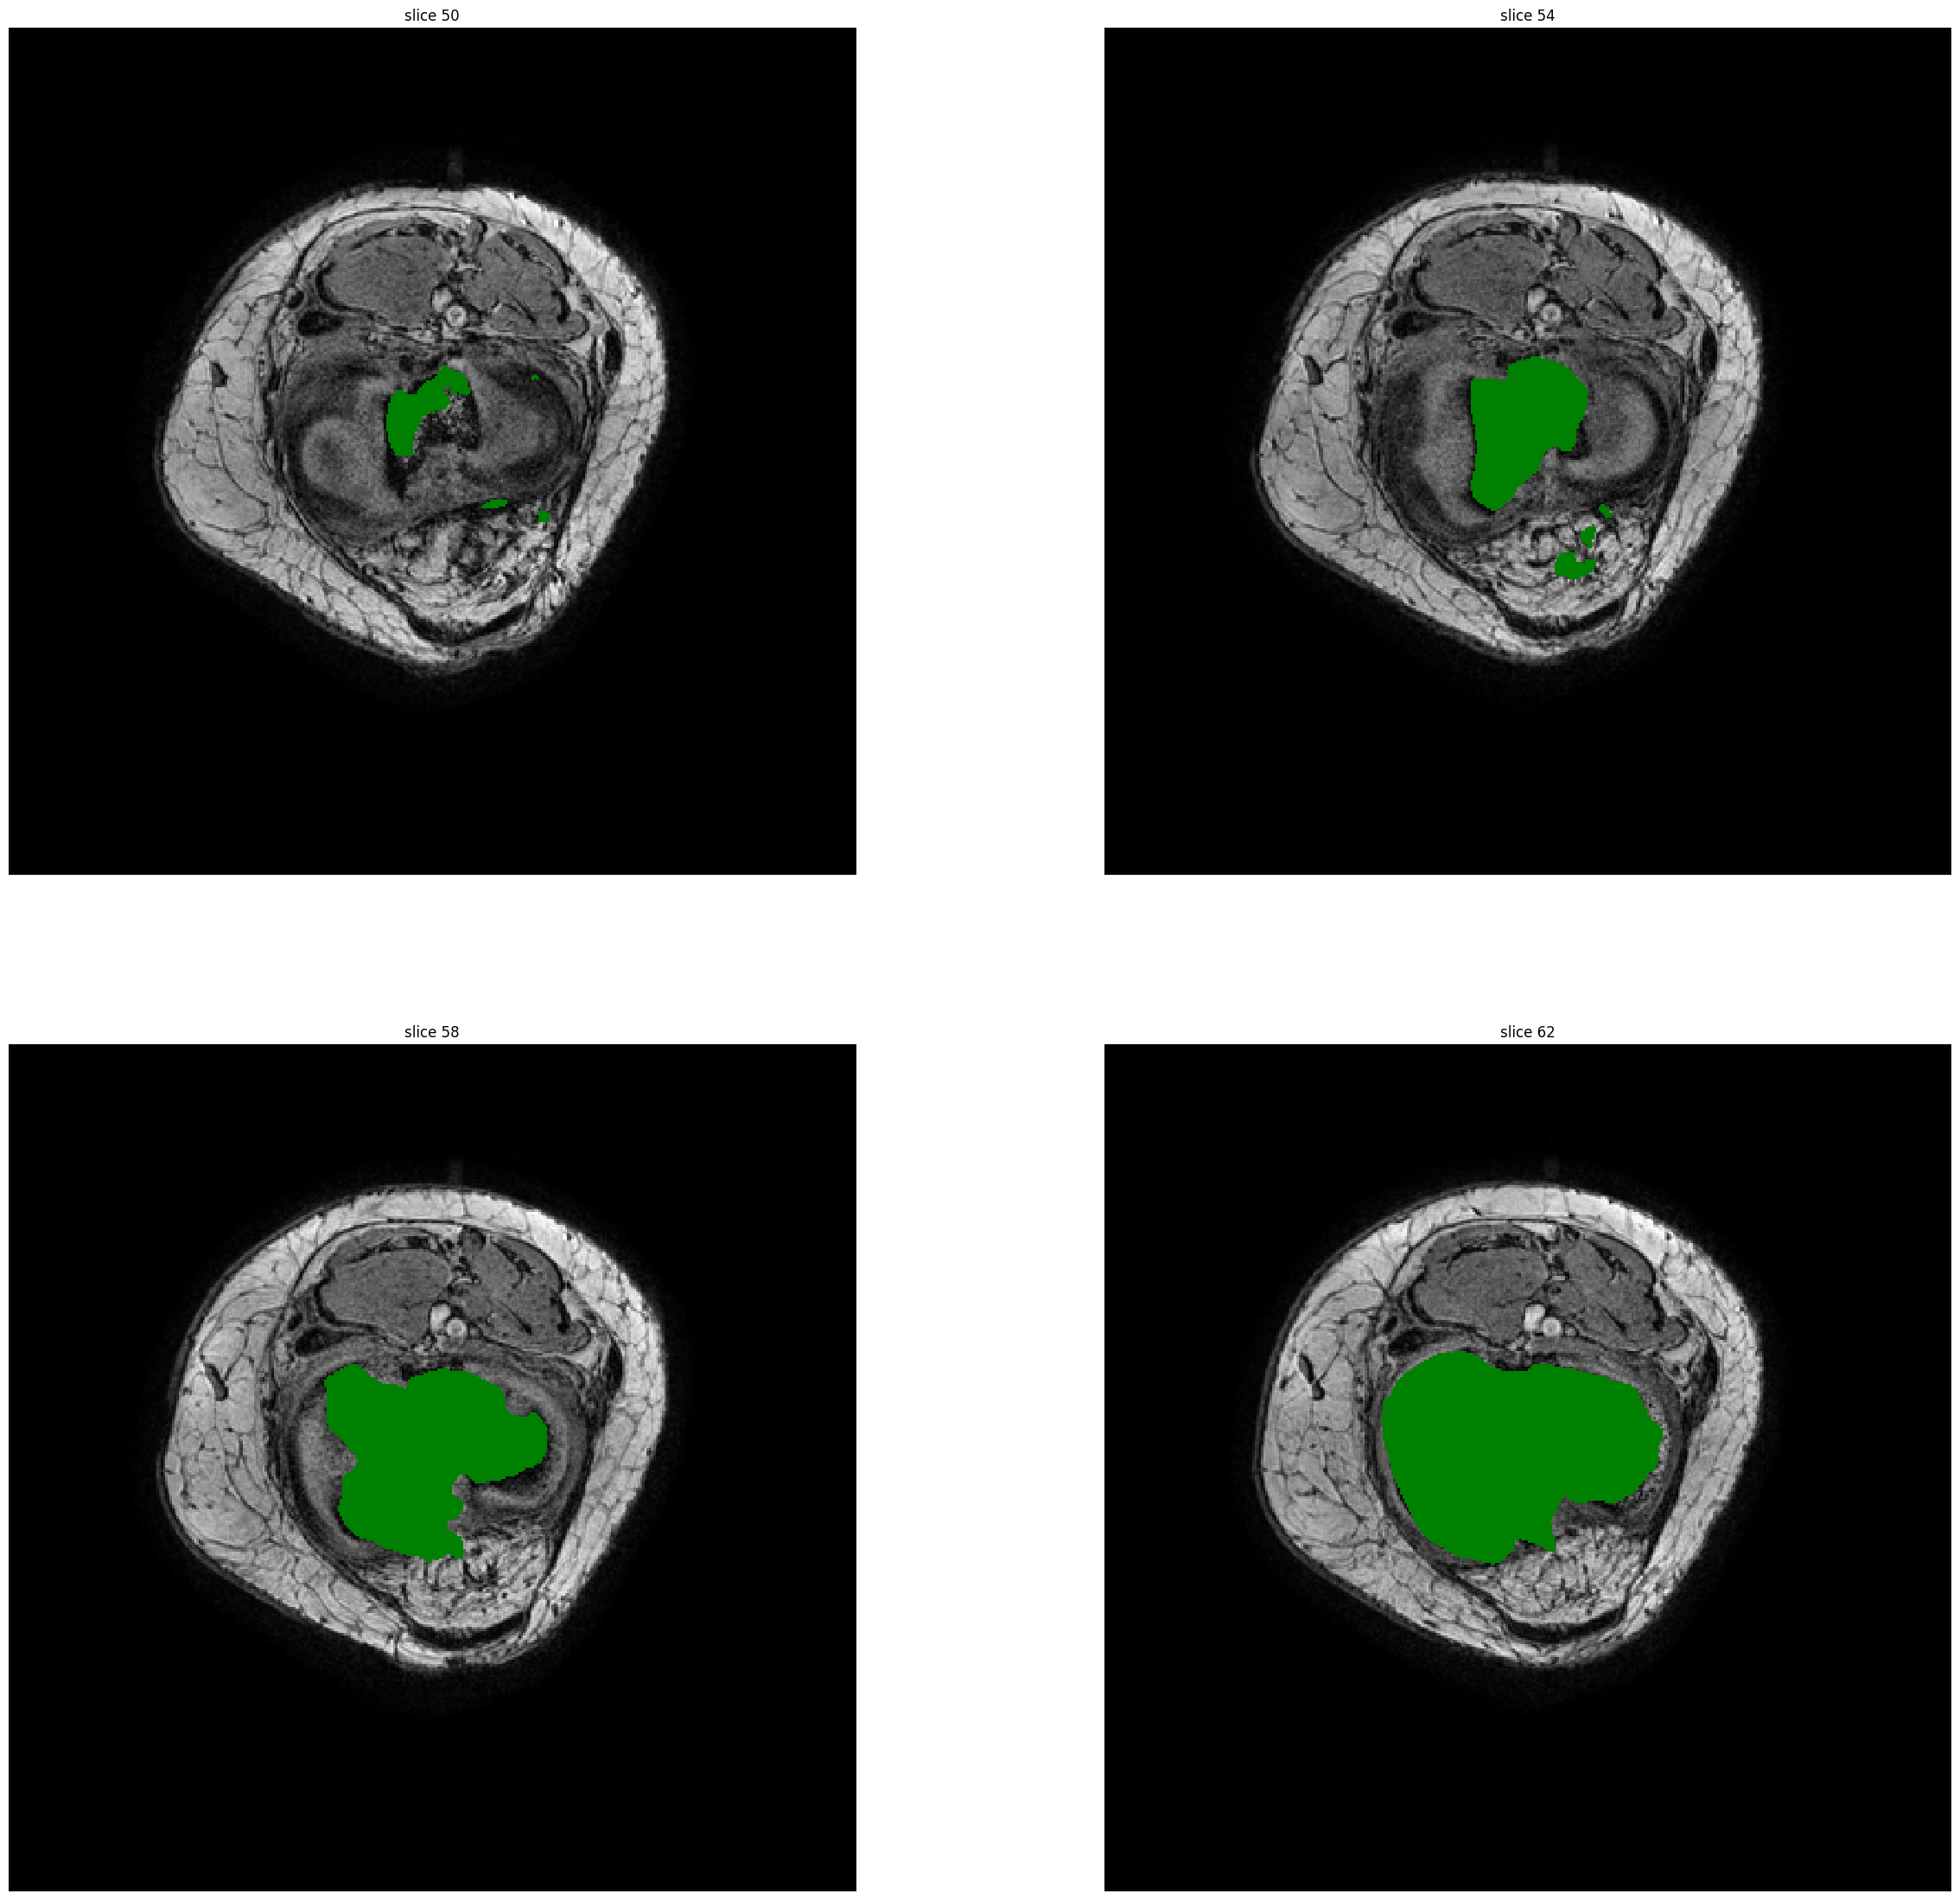

In [24]:
with h5py.File(TRAIN_DATASET_PATH + "MenisKI21_Prediction_10_InVivo_resized.h5", 'r') as hf:
    res = np.argmax(pred, axis=3)
    sample_stack(hf[prediction_ids[1] + '_dcm'][:], res, rows=2, cols=2, start_with=50, show_every=4)


In [3]:
predictions = []
with h5py.File(TRAIN_DATASET_PATH + "MenisKI21_Prediction_10_InVivo_resized_turned.h5", 'r') as hf:

    prediction_InVivo_turned_ids = [s[:-4] for s in list(hf.keys()) if "Test" in s.split("_") and "dcm" in s.split("_")]
    model_cropped_OAI_6 = keras.models.load_model(MODEL_PATH + "model_25_6_Classes_cropped.h5",
                                         custom_objects={'accuracy': tf.keras.metrics.MeanIoU(num_classes=2),
                                                         "dice_coef": dice_coef,
                                                         "dice_coef_medial": dice_coef_medial,
                                                         "dice_coef_lateral": dice_coef_lateral,
                                                         "precision": precision,
                                                         "sensitivity": sensitivity,
                                                         "specificity": specificity,
                                                         },
                                         compile=False)
    model_cropped_OAI_6.compile()


    pred_turned = model_cropped_OAI_6.predict(hf[prediction_InVivo_turned_ids[1] + "_dcm"][:], batch_size=15, verbose=1)

26/26 [==============================] - 22s 828ms/step


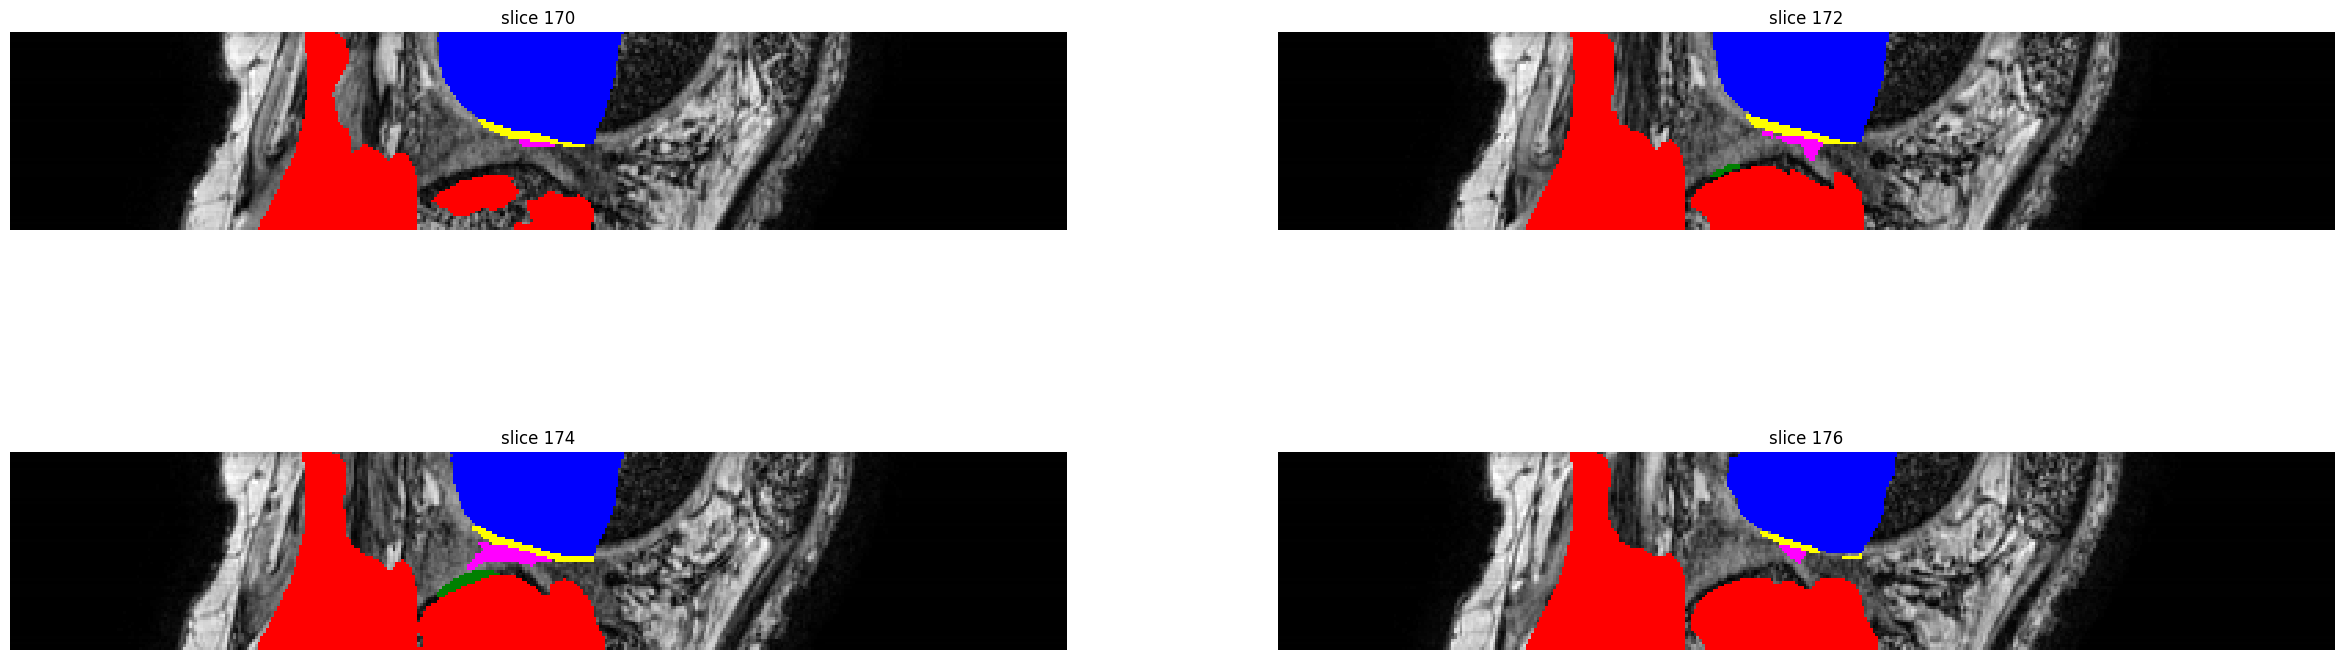

In [16]:
with h5py.File(TRAIN_DATASET_PATH + "MenisKI21_Prediction_10_InVivo_resized.h5", 'r') as hf:
    res_turned = np.argmax(pred_turned, axis=3)
    img = np.transpose(hf[prediction_InVivo_turned_ids[1] + '_dcm'][:],(2,0,1))
    img = np.flip(img)
    res_turned = np.flip(res_turned)
    sample_stack(img, res_turned, rows=2, cols=2, start_with=170, show_every=2,fig_size=[30,10])